# Solving a maze by using Reinforcement learning
## Import libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt 

## Maze definition

In [11]:
class Maze(object):
    def __init__(self):
        # 0: Empty field |  1: Wall |  2: Agent
        filename = "maze10x10.maze"
        self.loadMaze(filename)
        
        # Action space definition
        self.actionSpace = {'U': (-1,0), 'D': (1,0), 'L': (0,-1), 'R': (0,1)}
        
        # Steps counter
        self.steps = 0
        
        # Set of allowed states
        self.getAllowedStates()

    def loadMaze(self, filename):
        file = open(filename, 'r')
        lines = file.readlines()

        self.maze = np.zeros((len(lines),len(lines[0].split(" "))))
        self.rows = len(lines)
        self.cols = len(lines[0].split(" "))
        rows = 0
        cols = 0
        print("", end =" "),
        for line in lines:
            cols = 0
            for col in line.strip().split(" "):
                if col == "A":
                    self.maze[rows,cols] = 2
                    self.initialState = (rows, cols)
                    self.agentState = (rows, cols)
                elif col == "O":
                    self.maze[rows, cols] = 0
                elif col == "x":
                    self.maze[rows, cols] = 1
                elif col == "T":
                    self.maze[rows, cols] = 3
                    self.targetState = (rows, cols)
                cols += 1
            rows += 1
        
    def printMaze(self):
        print(" ")
        for row in self.maze:      
            for col in row:
                if col == 0:
                    print('O', end=' ')
                elif col == 1:
                    print('x', end=' ')
                elif col == 2:
                    print('A', end=' ')
                elif col == 3:
                    print('T', end=' ')
            print("")
    
    
    def isAllowedMovement(self, state, action):
        x, y = state
        x += self.actionSpace[action][0]
        y += self.actionSpace[action][1]
        
        # Validate borders
        if y<0 or x<0 or y>=self.rows or x>=self.cols:
            return False

        # Validate empty fields or goal
        if self.maze[x, y] == 0 or self.maze[x, y] == 2 or self.maze[x, y] == 3:
            return True
        else:
            return False

        
    # Get all allowed states for each postion in the maze
    def getAllowedStates(self):
        allowedStates= {}
        for x, row in enumerate(self.maze):
            for y, col in enumerate(row):
                # Filter valid states
                if self.maze[(x, y)] != 1:
                    # New array in the dictionary
                    allowedStates[(x,y)] = []
                    # List up allowed actions
                    for action in self.actionSpace:
                        if self.isAllowedMovement((x,y), action):
                            allowedStates[(x,y)].append(action)
        self.allowedStates = allowedStates

        
    def updateMaze(self, action):
        x, y = self.agentState
        self.maze[x, y] = 0   
        x += self.actionSpace[action][0]
        y += self.actionSpace[action][1]               
        self.agentState = (x, y)
        self.maze[x, y] = 2
        self.steps += 1

    def isGameOver(self):
        # Return True=End | False=Other
        if self.agentState == self.targetState :
            return True
        else:
            return False
    
    def getStateAndReward(self):
        reward = self.getReward()
        return self.agentState, reward

    def getReward(self):
        # Reward definition
        # 0: final state (goal)
        # -1: other case
        if self.agentState == self.targetState:
            return 0
        else:
            return -1

In [12]:
maze = Maze()
maze.printMaze()
maze.allowedStates

  
A O O O O O O O O O 
x x x O x x x x x x 
O O O O O O O O O O 
O x x x x x x x x x 
O O O O O O O O O x 
x x x x O x x x O x 
x x x x O x x O O x 
x x x x O O O O x x 
x x x x O x x x x x 
x x x x O O O O O T 


{(0, 0): ['R'],
 (0, 1): ['L', 'R'],
 (0, 2): ['L', 'R'],
 (0, 3): ['D', 'L', 'R'],
 (0, 4): ['L', 'R'],
 (0, 5): ['L', 'R'],
 (0, 6): ['L', 'R'],
 (0, 7): ['L', 'R'],
 (0, 8): ['L', 'R'],
 (0, 9): ['L'],
 (1, 3): ['U', 'D'],
 (2, 0): ['D', 'R'],
 (2, 1): ['L', 'R'],
 (2, 2): ['L', 'R'],
 (2, 3): ['U', 'L', 'R'],
 (2, 4): ['L', 'R'],
 (2, 5): ['L', 'R'],
 (2, 6): ['L', 'R'],
 (2, 7): ['L', 'R'],
 (2, 8): ['L', 'R'],
 (2, 9): ['L'],
 (3, 0): ['U', 'D'],
 (4, 0): ['U', 'R'],
 (4, 1): ['L', 'R'],
 (4, 2): ['L', 'R'],
 (4, 3): ['L', 'R'],
 (4, 4): ['D', 'L', 'R'],
 (4, 5): ['L', 'R'],
 (4, 6): ['L', 'R'],
 (4, 7): ['L', 'R'],
 (4, 8): ['D', 'L'],
 (5, 4): ['U', 'D'],
 (5, 8): ['U', 'D'],
 (6, 4): ['U', 'D'],
 (6, 7): ['D', 'R'],
 (6, 8): ['U', 'L'],
 (7, 4): ['U', 'D', 'R'],
 (7, 5): ['L', 'R'],
 (7, 6): ['L', 'R'],
 (7, 7): ['U', 'L'],
 (8, 4): ['U', 'D'],
 (9, 4): ['U', 'R'],
 (9, 5): ['L', 'R'],
 (9, 6): ['L', 'R'],
 (9, 7): ['L', 'R'],
 (9, 8): ['L', 'R'],
 (9, 9): ['L']}

## Agent definition

In [13]:
class Agent(object):
    def __init__(self, maze, alpha=0.15, epsilon=0.2):        
        self.stateHistory = [((0,0), 0)] # s, r
        self.V = {}  # Store V(s)
        self.epsilon = epsilon
        self.alpha = alpha   
        self.initReward(maze.allowedStates)  

    def initReward(self, allowedStates):
        # Initialize V(s) for each state s
        for state in allowedStates:     
            self.V[state] = np.random.uniform(low=-1.0,high=-0.1)

    def chooseAction(self, state, allowedMoves):
        # Agent choose actions using epsilon-greedy
        maxV = -10e15    
        nextMove = None 
        
        random_num = np.random.random()
        # Choose a random action using epsilin-greedy
        if random_num < self.epsilon:
            nextMove = np.random.choice(allowedMoves)  
        # Otherway, takes the best option
        else:            
            for action in allowedMoves:
                newState = tuple([sum(x) for x in zip(state, maze.actionSpace[action])])
                if self.V[newState] >= maxV:
                    maxV = self.V[newState]
                    nextMove = action            
        return nextMove

    def printV(self):
        for i in range(maze.rows):            
            for j in range(maze.cols):
                if (i,j) in self.V.keys():
                    print('%.6f' % self.V[(i,j)], end='\t')
                else:
                    print('X', end='\t\t')
            print('\n')

    def updateStateHistory(self, state, reward):
        # Stores the estate and reward in the stateHistory
        self.stateHistory.append((state, reward))

    def learn(self):
        # target(s): Accumulated reward  for S's state
        target = 0 # Initial target at the end of the episode
        
        for prev, reward in reversed(self.stateHistory):
            # Executes the update rule
            self.V[prev] = self.V[prev]  + self.alpha * (target - self.V[prev])            
            target += reward

        self.stateHistory = []
        self.epsilon -= 10e-5

## Reinforcement learning algorithm

  episode 1, steps 1001
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

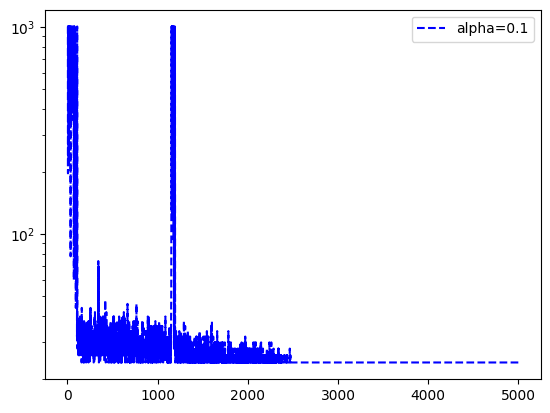

In [14]:
maze = Maze()
agent = Agent(maze, alpha=0.1, epsilon=0.25)
moveHistory = []
episodes = 5000

for i in range(episodes):
    while not maze.isGameOver():
        state, _ = maze.getStateAndReward()
        action = agent.chooseAction(state, maze.allowedStates[state])
        maze.updateMaze(action)
        state, reward = maze.getStateAndReward()
        agent.updateStateHistory(state, reward)
        if maze.steps > 1000:
            maze.agentState = maze.targetState
    agent.learn()
    moveHistory.append(maze.steps)
    maze = Maze()
    
    if i % 1000 == 0:
        print(f'episode {i+1}, steps {moveHistory[-1]}')


plt.semilogy(moveHistory, 'b--')
plt.legend(['alpha=0.1'])
plt.show()

## Table of V values

In [15]:
agent.printV()

-57.077028	-22.000000	-21.000000	-20.000000	-27.042216	-493.461774	-920.465792	-917.797567	-705.938877	-507.696529	

X		X		X		-19.000000	X		X		X		X		X		X		

-15.000000	-16.000000	-17.000000	-18.000000	-46.616817	-579.560844	-754.296052	-369.567245	-289.000068	-286.346036	

-14.000000	X		X		X		X		X		X		X		X		X		

-13.000000	-12.000000	-11.000000	-10.000000	-9.000000	-13.882477	-267.081002	-555.025037	-571.707652	X		

X		X		X		X		-8.000000	X		X		X		-417.573703	X		

X		X		X		X		-7.000000	X		X		-321.962692	-289.873986	X		

X		X		X		X		-6.000000	-7.429431	-127.970102	-313.052021	X		X		

X		X		X		X		-5.000000	X		X		X		X		X		

X		X		X		X		-4.000000	-3.000000	-2.000000	-1.000000	-0.000000	-0.000000	



## Test the agent

In [16]:
maze = Maze()

while not maze.isGameOver():
    state, _ = maze.getStateAndReward()
    maze.printMaze()
    action = agent.chooseAction(state, maze.allowedStates[state])
    maze.updateMaze(action)
    print("\n")
    
maze.printMaze() 

  
A O O O O O O O O O 
x x x O x x x x x x 
O O O O O O O O O O 
O x x x x x x x x x 
O O O O O O O O O x 
x x x x O x x x O x 
x x x x O x x O O x 
x x x x O O O O x x 
x x x x O x x x x x 
x x x x O O O O O T 


 
O A O O O O O O O O 
x x x O x x x x x x 
O O O O O O O O O O 
O x x x x x x x x x 
O O O O O O O O O x 
x x x x O x x x O x 
x x x x O x x O O x 
x x x x O O O O x x 
x x x x O x x x x x 
x x x x O O O O O T 


 
O O A O O O O O O O 
x x x O x x x x x x 
O O O O O O O O O O 
O x x x x x x x x x 
O O O O O O O O O x 
x x x x O x x x O x 
x x x x O x x O O x 
x x x x O O O O x x 
x x x x O x x x x x 
x x x x O O O O O T 


 
O O O A O O O O O O 
x x x O x x x x x x 
O O O O O O O O O O 
O x x x x x x x x x 
O O O O O O O O O x 
x x x x O x x x O x 
x x x x O x x O O x 
x x x x O O O O x x 
x x x x O x x x x x 
x x x x O O O O O T 


 
O O O O O O O O O O 
x x x A x x x x x x 
O O O O O O O O O O 
O x x x x x x x x x 
O O O O O O O O O x 
x x x x O x x x O x 
x x x x O x x O